In [1]:
from sqlalchemy import create_engine

engine = create_engine(r"sqlite:///C:/Users/blinklet/Documents/chinook-database/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite")

In [2]:
from sqlalchemy import inspect

inspector = inspect(engine)

print(inspector.get_table_names())

['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


In [46]:
from pprint import pprint

# Columns in table "Album"
pprint(inspector.get_columns("Album"))
print()

# Primary Key for table "Album"
pprint(inspector.get_pk_constraint("Album"))

[{'autoincrement': 'auto',
  'default': None,
  'name': 'AlbumId',
  'nullable': False,
  'primary_key': 1,
  'type': INTEGER()},
 {'autoincrement': 'auto',
  'default': None,
  'name': 'Title',
  'nullable': False,
  'primary_key': 0,
  'type': NVARCHAR(length=160)},
 {'autoincrement': 'auto',
  'default': None,
  'name': 'ArtistId',
  'nullable': False,
  'primary_key': 0,
  'type': INTEGER()}]

{'constrained_columns': ['AlbumId'], 'name': None}


In [47]:
for table_name in inspector.get_table_names():

    print(f"Table = {table_name}")
    
    print(f"Columns = ", end="")
    col_names_list = []
    for col in inspector.get_columns(table_name):
        col_names_list.append(col['name'])
    print(*col_names_list, sep=", ")
    
    print(f"Primary Keys = ", end="")
    pk_list = inspector.get_pk_constraint(table_name)
    pk_name_list = pk_list["constrained_columns"]
    print(*pk_name_list, sep=", ")

    fk_list = inspector.get_foreign_keys(table_name)
    if fk_list:
        print(f"Foreign Keys:")
        fk_name_list = []
        fk_reftbl_list = []
        fk_refcol_list = []
        
        for fk in fk_list:
            fk_name_list.append(*fk['constrained_columns'])
            fk_reftbl_list.append(fk['referred_table'])
            fk_refcol_list.append(*fk['referred_columns'])
            
        fk_info = zip(fk_name_list, fk_reftbl_list, fk_refcol_list)
        
        for n, t, c in fk_info:
            print(f"    {n} ---> {t}:{c}")

    print()

Table = Album
Columns = Title, ArtistId, AlbumId
Primary Keys = AlbumId
Foreign Keys:
    ArtistId ---> Artist:ArtistId

Table = Artist
Columns = ArtistId, Name
Primary Keys = ArtistId

Table = Customer
Columns = CustomerId, FirstName, LastName, Company, Address, City, State, Country, PostalCode, Phone, Fax, Email, SupportRepId
Primary Keys = CustomerId
Foreign Keys:
    SupportRepId ---> Employee:EmployeeId

Table = Employee
Columns = EmployeeId, LastName, FirstName, Title, ReportsTo, BirthDate, HireDate, Address, City, State, Country, PostalCode, Phone, Fax, Email
Primary Keys = EmployeeId
Foreign Keys:
    ReportsTo ---> Employee:EmployeeId

Table = Genre
Columns = GenreId, Name
Primary Keys = GenreId

Table = Invoice
Columns = InvoiceId, CustomerId, InvoiceDate, BillingAddress, BillingCity, BillingState, BillingCountry, BillingPostalCode, Total
Primary Keys = InvoiceId
Foreign Keys:
    CustomerId ---> Customer:CustomerId

Table = InvoiceLine
Columns = InvoiceLineId, InvoiceId, Tra

In [3]:
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session

Base = automap_base()
Base.prepare(autoload_with=engine)

print()
print(*Base.metadata.tables, sep=", ")

print(repr(Base.metadata.tables['Album']))
print()
meta = Base.metadata.tables.items()
for i in meta:
    print(i, end="\n\n")



Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, Track, MediaType, Playlist, PlaylistTrack
Table('Album', MetaData(), Column('AlbumId', INTEGER(), table=<Album>, primary_key=True, nullable=False), Column('Title', NVARCHAR(length=160), table=<Album>, nullable=False), Column('ArtistId', INTEGER(), ForeignKey('Artist.ArtistId'), table=<Album>, nullable=False), schema=None)

('Album', Table('Album', MetaData(), Column('AlbumId', INTEGER(), table=<Album>, primary_key=True, nullable=False), Column('Title', NVARCHAR(length=160), table=<Album>, nullable=False), Column('ArtistId', INTEGER(), ForeignKey('Artist.ArtistId'), table=<Album>, nullable=False), schema=None))

('Artist', Table('Artist', MetaData(), Column('ArtistId', INTEGER(), table=<Artist>, primary_key=True, nullable=False), Column('Name', NVARCHAR(length=120), table=<Artist>), schema=None))

('Customer', Table('Customer', MetaData(), Column('CustomerId', INTEGER(), table=<Customer>, primary_key=True, nullable=False),

In [41]:
print(*Base.classes.keys(), sep=", ")

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, Track, MediaType, Playlist


In [95]:
def table_info(table_name):
    table = Base.metadata.tables[table_name]
    print(f"Table: {table_name}")
    print(f"Columns: ")
    for col in table.columns:
        print(f"   {col.name:15}", end="")
        if col.primary_key:
            print(f"*Primary Key*   ", end="")
        if col.foreign_keys:
            print(f"{set(col.foreign_keys)}", end="")
            print(dir(col.foreign_keys))
        print()
    print()

In [260]:
from sqlalchemy.schema import ForeignKey
from tabulate import tabulate

def table_info(table_name):
    headers = [
        'Column Name',
        'Primary Key',
        'Foreign Key', 
        'Relationship'
    ]

    body = list()
    table = Base.metadata.tables[table_name]
    
    print(f"Table: {table_name}")
    
    for col in table.columns:
        line = dict.fromkeys(headers)
        line['Column Name'] = col.name
        
        if col.primary_key:
            line['Primary Key'] = "YES"
        
        if col.foreign_keys:
            line['Foreign Key'] = "YES"
            z = set(col.expression.foreign_keys).pop()
            if isinstance(z, ForeignKey):
                line['Relationship'] = z.target_fullname
        
        body.append(line)
    
    rows =  [x.values() for x in body]
    return(
        tabulate(
            rows, 
            headers, 
            colalign=('left','center','center','left'), 
            tablefmt='psql'
        )
    )


In [261]:
print(table_info("PlaylistTrack"))
print("\n")
print(table_info("Track"))


Table: PlaylistTrack
+---------------+---------------+---------------+---------------------+
| Column Name   |  Primary Key  |  Foreign Key  | Relationship        |
|---------------+---------------+---------------+---------------------|
| PlaylistId    |      YES      |      YES      | Playlist.PlaylistId |
| TrackId       |      YES      |      YES      | Track.TrackId       |
+---------------+---------------+---------------+---------------------+


Table: Track
+---------------+---------------+---------------+-----------------------+
| Column Name   |  Primary Key  |  Foreign Key  | Relationship          |
|---------------+---------------+---------------+-----------------------|
| TrackId       |      YES      |               |                       |
| Name          |               |               |                       |
| AlbumId       |               |      YES      | Album.AlbumId         |
| MediaTypeId   |               |      YES      | MediaType.MediaTypeId |
| GenreId     

'+---------------+---------------+---------------+-----------------+\n| Column Name   |  Primary Key  |  Foreign Key  | Relationship    |\n|---------------+---------------+---------------+-----------------|\n| AlbumId       |      YES      |               |                 |\n| Title         |               |               |                 |\n| ArtistId      |               |      YES      | Artist.ArtistId |\n+---------------+---------------+---------------+-----------------+'

In [4]:
Album = Base.classes.Album
Artist = Base.classes.Artist
Customer = Base.classes.Customer
Employee = Base.classes.Employee
Genre = Base.classes.Genre
Invoice = Base.classes.Invoice
InvoiceLine = Base.classes.InvoiceLine
MediaType = Base.classes.MediaType
Playlist = Base.classes.Playlist
Track = Base.classes.Track
playlisttrack = Base.metadata.tables['PlaylistTrack']

In [5]:
import pandas as pd

#session1 = Session(engine)

albums = pd.read_sql_table(table_name='Album', con=engine)

print(albums)

     AlbumId                                              Title  ArtistId
0          1              For Those About To Rock We Salute You         1
1          2                                  Balls to the Wall         2
2          3                                  Restless and Wild         2
3          4                                  Let There Be Rock         1
4          5                                           Big Ones         3
..       ...                                                ...       ...
342      343                             Respighi:Pines of Rome       226
343      344  Schubert: The Late String Quartets & String Qu...       272
344      345                                Monteverdi: L'Orfeo       273
345      346                              Mozart: Chamber Music       274
346      347  Koyaanisqatsi (Soundtrack from the Motion Pict...       275

[347 rows x 3 columns]


In [ ]:
print(pd.options.display.max_rows)
print(pd.options.display.max_columns)

In [ ]:
artists = pd.read_sql_table(table_name='Artist', con=engine)

print(artists.head())

In [ ]:
df1 = pd.merge(left = albums, right = artists, how = 'inner')
print(df1.head())
print(df1.shape)

In [ ]:
df1.drop('ArtistId', axis=1).rename(columns = {'Name':'Artist'})

In [ ]:
df2 = (pd
     .merge(albums, artists)
     .drop('ArtistId', axis=1)
     .rename(columns = {'Name':'Artist'}))
print(df2.head())
print(df2.shape)

In [ ]:
tracks = pd.read_sql_table(table_name='Track', con=engine)

print(tracks.head())
print(tracks.shape)

In [ ]:
df3 = (pd
     .merge(df2, tracks)
     .drop(['AlbumId','TrackId',
            'Bytes','UnitPrice',
            'MediaTypeId','GenreId'], axis=1)
     .rename(columns = {'Name':'Track', 
                        'Title':'Album',
                        'Milliseconds':'Length(ms)'}))

print(df3.shape)
df3.head().style.format(thousands=",")

In [ ]:
print(f"Album table relationships")
print()
for relationship in inspect(Album).relationships:
    print(f"Relationship: {relationship}")
    print(f"Direction:    {relationship.direction}")
    print(f"Joined Table: {relationship.target}")
    print()

In [ ]:
from sqlalchemy import select

session = Session(engine)

statement = select(Album)
first_album = session.scalar(statement)

print(f"Album:  {first_album.Title}")
print(f"Artist: {first_album.artist.Name}")
print(f"Tracks:")
for t in first_album.track_collection:
    print(f"    {t.Name}")

session.close()

In [8]:
from sqlalchemy import select

print(f"Get inner join of tables Album, Track, and Artist")
statement = (select(Album, Track, Artist)
     .join(Track)
     .join(Artist)
    )

df4 = pd.read_sql(statement, con=engine)

print(df4.shape)
display(df4.head())

Get inner join of tables Album, Track, and Artist
(3503, 14)


,AlbumId,Title,ArtistId,TrackId,Name,AlbumId_1,MediaTypeId,GenreId,Composer,Milliseconds,Bytes,UnitPrice,ArtistId_1,Name_1
0,1,For Those About To Rock We Salute You,1,1,For Those About To Rock (We Salute You),1,1,1,"Angus Young, Malcolm Young, Brian Johnson",343719,11170334,0.99,1,AC/DC
1,2,Balls to the Wall,2,2,Balls to the Wall,2,2,1,None,342562,5510424,0.99,2,Accept
2,3,Restless and Wild,2,3,Fast As a Shark,3,2,1,"F. Baltes, S. Kaufman, U. Dirkscneider & W. Ho...",230619,3990994,0.99,2,Accept
3,3,Restless and Wild,2,4,Restless and Wild,3,2,1,"F. Baltes, R.A. Smith-Diesel, S. Kaufman, U. D...",252051,4331779,0.99,2,Accept
4,3,Restless and Wild,2,5,Princess of the Dawn,3,2,1,Deaffy & R.A. Smith-Diesel,375418,6290521,0.99,2,Accept


In [ ]:
print(f"Get inner join of tables Album, Track, and Artist")

statement = (select(Album.Title.label("Album"),
            Artist.Name.label("Artist"),
            Track.Name.label("Track"),
            Track.Composer, 
            Track.Milliseconds.label("Length"))
     .join(Track)
     .join(Artist)
    )

dataframe = pd.read_sql(sql=statement, con=engine)

print(dataframe.shape)
display(dataframe.head().style.format(thousands=","))

In [ ]:
albums = pd.read_sql_table(table_name='Album', con=engine)
artists = pd.read_sql_table(table_name='Artist', con=engine)
tracks = pd.read_sql_table(table_name='Track', con=engine)

df1 = (pd
     .merge(albums, artists)
     .rename(columns = {'Name':'Artist'}))

data = (pd
     .merge(df1, tracks)
     .rename(columns = {'Name':'Track', 
                        'Title':'Album',
                        'Milliseconds':'Length'}))

print(f"Longest track: {data.Length.max():d}")
print(f"Shortest track: {data.Length.min():,}")
print(f"How many blanks in Composer column?: "
      f"{data.Composer.isnull().sum():,}")
print(f"Track length mean: {data.Length.mean():,.2f}")
print(f"Track length median: {data.Length.median()}")
print(f"Artist mode: {data.Artist.mode()[0]}")
print(f"Correlation between Length and UnitPrice: "
      f"{data['Length'].corr(data['UnitPrice']):,.2f}")
print(f"Track length standard deviation: "
      f"{data.Length.std():,.2f}")

print(data.Artist.describe())


In [ ]:
from tabulate import tabulate

print(f"Track length standard deviation for a sample of artists:")
print(tabulate(
        data.groupby(['Artist'])['Length']
        .std()
        .dropna()
        .sample(3)
        .to_frame(), 
        headers = ['Artist','Track Length\nStd Dev'], 
        tablefmt="grid"))
print()
print(f"Longest tracks, with artist name:")
print(tabulate(
        data[['Track','Length','Artist']]
        .nlargest(3, 'Length'), 
        headers="keys", 
        tablefmt='grid', 
        showindex=False))
print()
print(f"Number of tracks per artist, from a sample of artists::")
print(tabulate(
        data
        .groupby('Artist')['Track']
        .count()
        .sample(3)
        .to_frame(), 
        headers = ['Artist','# Tracks'], 
        tablefmt="grid"))
print()
print(f"Shortest track by Artist=Guns N' Roses: ")
gnr = data.loc[data['Artist'] == "Guns N' Roses"]
gnr_shortest = gnr[['Track','Length']].nsmallest(3, 'Length')
print(tabulate(
        gnr_shortest, 
        headers="keys", 
        tablefmt='grid', 
        showindex=False))       

In [ ]:
print(f"Track length standard deviation for a sample of artists:")
pd.options.display.float_format = '{:,.2f}'.format
pd.options.styler.format.thousands= ','

display(
    data
    .groupby(['Artist'])['Length'] 
    .count()
    .sample(3)
    .to_frame()
)
print()
print(f"Longest tracks, with artist name:")
display(
    data[['Track','Length','Artist']]
    .nlargest(3, 'Length')
    .style.hide(axis="index")
)

print()
print(f"Number of tracks per artist, from a sample of artists::")
display(
    data
    .groupby('Artist')['Track']
    .count()
    .sample(3)
    .to_frame()
)
print()
print(f"Shortest tracks by Artist=Guns N' Roses: ")
gnr = data.loc[data.Artist == "Guns N' Roses"]
gnr_shortest = gnr[['Track','Length']].nsmallest(3, 'Length')
display(
    gnr_shortest
    .style.hide(axis="index")
)

In [ ]:
from sqlalchemy import select, func

with Session(engine) as session:
    statement = select(func.max(Track.Milliseconds))
    length = session.scalar(statement)

print(f"Longest track length: {length}")



In [ ]:
with Session(engine) as session:
    result = session.execute(statement)
    print(result)
    print(type(result))

In [ ]:
with Session(engine) as session:
    result = session.execute(statement)
    print(next(result))
    print(next(result))
    print(type(result))

In [ ]:
with Session(engine) as session:
    result = session.execute(statement)
    x = next(result).Artist
    print(x)
    print(type(x))

In [ ]:
with Session(engine) as session:
    limit = 4
    result = session.execute(statement)
    for index, item in enumerate(result, start=1):
        print(item)
        if index == limit:
            break

In [ ]:
table = []
limit = 4

with Session(engine) as session:
    result = session.execute(statement)
    for index, item in enumerate(result, start=1):
        table.append(item)
        if index == limit:
            break
    headers = session.execute(statement).keys()
    print(type(headers))
    
print(type(headers))
print(table)

In [ ]:
from collections import namedtuple

with Session(engine) as session:
    headers = session.execute(statement).keys()
    table = session.execute(statement).fetchmany(4)

print(type(headers))
print(next(iter(headers)))
print(type(table))
for row in table:
    print(type(row))

In [ ]:
from tabulate import tabulate

with Session(engine) as session:
    print(session.execute(statement))
    print()
    print(session.execute(statement).first())
    print()
    print(session.execute(statement).fetchmany(2))
    print()
    print(session.execute(statement.limit(2)).fetchall())
    print()
    print(session.scalars(statement))
    print()
    print(session.scalars(statement).first())
    print()
    print(session.scalars(statement).fetchmany(2))
    print()
    print(session.scalars(statement.limit(2)).fetchall())
    print()
    print(session.scalar(statement))

In [ ]:
statement = (select(Album.Title.label("Album"),
            Artist.Name.label("Artist"),
            Track.Name.label("Track"),
            Track.Composer, 
            Track.Milliseconds.label("Length"))
     .join(Track)
     .join(Artist)
     .where(Artist.Name == 'Alice In Chains')
    )

with Session(engine) as session:
    result = session.execute(statement).fetchall()
    
print()
for row in result:
    print(f"Track name: {row.Track:18} Composer: {row.Composer}")

In [ ]:
print(f"Experiment with returned data types\n")

statement = (select(Album.Title.label("Album"),
            Artist.Name.label("Artist"),
            Track.Name.label("Track"),
            Track.Composer, 
            Track.Milliseconds.label("Length"))
     .join(Track)
     .join(Artist)
    )

with Session(engine) as session:
    query = session.execute(statement.where(Artist.Name == 'Alice In Chains'))
    headings = query.keys()
    result = query.fetchmany(4)
    
#     query = session.execute(statement.where(Artist.Name == 'Alice In Chains').limit(4))
#     result_as_dicts = query.mappings().all()

print(result)

print()
for row in result:
    print(f"Track name: {row.Track}\tComposer: {row.Composer}")

print()
for row in result_as_dicts:
    print(row)

print()
for row in result:
    print(f"Track name: {row['Track']}\tComposer: {row['Composer']}")
    


In [ ]:
statement = (select(Artist).where(Artist.Name=='Alice In Chains'))

dataframe = pd.read_sql(sql=statement, con=engine)

print(dataframe.shape)
print(dataframe.head(5))

In [ ]:
print(f"Experiment with returned data types\n")

with Session(engine) as session:
    query = session.execute(statement.filter(Artist.Name == 'Alice In Chains'))
    headings = query.keys()
    result = query.fetchmany(4)
    
print(result)

print()
for row in result:
    print(f"Track name: {row.Track}\tComposer: {row.Composer}")

In [ ]:
with Session(engine) as session:
    query = session.execute(statement)
    result_headings = query.keys()
    result = query.fetchmany(5)

for x in result:
    print(x)

In [ ]:
print("similar to pandas select() method")
print()
with Session(engine) as session:
    result = session.execute(statement.order_by(func.random()).limit(2)).fetchall()

print(result)

In [ ]:
length = (session1
            .query(func.min(Track.Milliseconds))
            .scalar()
         )

print(f"Shortest track length: {length}")

In [ ]:
statement = (select(Artist))

dataframe = pd.read_sql(sql=statement, con=engine)

print(dataframe.shape)
print(dataframe.head(5))

In [ ]:
statement = (select(Artist).filter(Artist.Name=='Alice In Chains'))

dataframe = pd.read_sql(sql=statement, con=engine)

print(dataframe.shape)
print(dataframe.head(5))

In [ ]:
statement = (select(Artist).order_by(func.random()).limit(5))

dataframe = pd.read_sql(sql=statement, con=engine)

print(dataframe.shape)
print(dataframe.head(5))

In [ ]:
from sqlalchemy import select

session = Session(engine)

statement = select(Album)
first_album = session.scalars(statement.limit(3))
print(dir(first_album))

for x in first_album:

    print(f"Album:  {x.Title}")
    print(f"Artist: {x.artist.Name}")
    print(f"Tracks:")
    for t in x.track_collection:
        print(f"    {t.Name}")

session.close()

In [ ]:
statement = (select(Album.Title.label("Album"),
            Artist.Name.label("Artist"),
            Track.Name.label("Track"),
            Track.Composer, 
            Track.Milliseconds.label("Length"))
     .join(Track)
     .join(Artist)
    )

session = Session(engine)

first_album = session.execute(statement.limit(3))

for x in first_album:
    print(f"Album:  {x.Album}\tArtist: {x.Artist}\tTrack: {x.Track}")

print()

session.close()

In [ ]:
print(f"Names of all the tracks purchased by each customer")

statement = (select(Customer.FirstName,
                    Customer.LastName,
                    Customer.Country,
                    InvoiceLine.Quantity,
                    InvoiceLine.UnitPrice,
                    Track.Name,
                    Album.Title,
                    Artist.Name
                    )
                .join_from(Customer, Invoice)
                .join_from(Invoice, InvoiceLine)
                .join_from(InvoiceLine, Track)
                .join_from(Track, Album)
                .join_from(Album, Artist))

dataframe = pd.read_sql(sql=statement, con=engine)

print(dataframe.shape)
display(dataframe.head(5))




In [ ]:
# Creating ON statements where you need to be explicit about what is being joined

statement = (select(Customer.FirstName,
                    Customer.LastName,
                    Customer.Country,
                    InvoiceLine.Quantity,
                    InvoiceLine.UnitPrice,
                    Track.Name,
                    Album.Title,
                    Artist.Name,
                    Genre.Name
                    )
                .join(Invoice, Customer.CustomerId == Invoice.CustomerId)
                .join(InvoiceLine, Invoice.InvoiceId == InvoiceLine.InvoiceId)
                .join(Track, InvoiceLine.TrackId == Track.TrackId)
                .join(Album, Track.AlbumId == Album.AlbumId)
                .join(Genre, Track.GenreId == Genre.GenreId)
                .join(Artist, Album.ArtistId == Artist.ArtistId))

print(statement)
print()

statement = (select(Customer.FirstName,
                    Customer.LastName,
                    Customer.Country,
                    InvoiceLine.Quantity,
                    InvoiceLine.UnitPrice,
                    Track.Name,
                    Album.Title,
                    Artist.Name,
                    Genre.Name
                    )
                .join_from(Customer, Invoice)
                .join_from(Invoice, InvoiceLine)
                .join_from(InvoiceLine, Track)
                .join(Album)
                .join(Genre)
                .join(Artist))

print(statement)
print()

# statement = (select(Customer.FirstName,
#                     Customer.LastName,
#                     Customer.Country,
#                     InvoiceLine.Quantity,
#                     InvoiceLine.UnitPrice,
#                     Track.Name,
#                     Album.Title,
#                     Artist.Name,
#                     Genre.Name
#                     )
#                 .join_from(Artist, Album)
#                 .join_from(Genre, Track)
#                 .join_from(Album, Track)
#                  .join(InvoiceLine)
#                  .join(InvoiceLine)
#             )

session = Session(engine)
print(session.execute(statement).first())
print(session.execute(statement).fetchmany(2))
print(session.execute(statement.limit(2)).fetchall())
print(session.scalars(statement))
print(session.scalars(statement).first())
print(session.scalars(statement).fetchmany(2))
print(session.scalars(statement.limit(2)).fetchall())
print(session.scalar(statement))
session.close()

# join(user_table, address_table,
#          user_table.c.id == address_table.c.user_id)


dataframe = pd.read_sql(sql=statement, con=engine)
print()
print(dataframe.shape)
display(dataframe.head(5))

In [ ]:
print(f"Names of all the tracks purchased by each customer")

statement = (select(Customer.FirstName,
                    Customer.LastName,
                    Customer.Country,
                    InvoiceLine.Quantity,
                    InvoiceLine.UnitPrice
                    )
                .select_from(Customer)
                .join(Invoice)
                .select_from(Invoice)
                .join(InvoiceLine))

dataframe = pd.read_sql(sql=statement, con=engine)

print(dataframe.shape)
display(dataframe.head(5))


In [ ]:
print(f"Names of all the tracks purchased by each customer")

statement = (select(Customer.FirstName,
                    Customer.LastName,
                    Customer.Country,
                    Track.Name.label("Track"),
                    Album.Title.label("Album"),
                    Artist.Name.label("Artist"),
                    InvoiceLine.Quantity,
                    InvoiceLine.UnitPrice
                    )
                .join(InvoiceLine)
                .join(Customer, Invoice.CustomerId)
                .join_from(InvoiceLine, Track)
                .join_from(Track, Album)
                .join_from(Album, Artist))

print(statement)
# dataframe = pd.read_sql(sql=statement, con=engine)

# print(dataframe.shape)
# display(dataframe.head(5))

In [ ]:
print(f"Names of all the tracks purchased by each customer")

statement = (select(Playlist.Name.label("Playlist"),
                    Track.Name.label("Track"),
                    Album.Title.label("Album"),
                    Artist.Name.label("Artist")
                    )
                .join_from(Playlist, playlisttrack)
                .join_from(playlisttrack, Track)
                .join_from(Track, Album)
                .join_from(Album, Artist))

dataframe = pd.read_sql(sql=statement, con=engine)

print(dataframe.shape)
display(dataframe.head(5).style.format(thousands=","))

In [ ]:
statement = (select(Playlist.Name.label("Playlist"),
                    Track.Name.label("Track"),
                    Album.Title.label("Album"),
                    Artist.Name.label("Artist")
                    )
                .join_from(Playlist, playlisttrack)
                .join_from(playlisttrack, Track)
                .join_from(Track, Album)
                .join_from(Album, Artist))

dataframe = pd.read_sql(sql=statement.order_by(func.random()).limit(5), con=engine)

print(dataframe.shape)
display(dataframe.head(5))

In [ ]:
from sqlalchemy import create_engine, inspect, select
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
import pandas as pd
from tabulate import tabulate

engine = create_engine(r"sqlite:///C:/Users/blinklet/Documents/chinook-database/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite")
Base = automap_base()
Base.prepare(autoload_with=engine)

Album = Base.classes.Album
Artist = Base.classes.Artist
Customer = Base.classes.Customer
Employee = Base.classes.Employee
Genre = Base.classes.Genre
Invoice = Base.classes.Invoice
InvoiceLine = Base.classes.InvoiceLine
MediaType = Base.classes.MediaType
Playlist = Base.classes.Playlist
Track = Base.classes.Track
playlisttrack = Base.metadata.tables['PlaylistTrack']

statement = (select(Playlist.Name.label("Playlist"),
                Track.Name.label("Track"),
                Album.Title.label("Album"),
                Artist.Name.label("Artist")
                )
            .join_from(Playlist, playlisttrack)
            .join_from(playlisttrack, Track)
            .join_from(Track, Album)
            .join_from(Album, Artist))

with Session(engine) as session4:
    headers = session.execute(statement).keys()
    table = session.execute(statement).fetchmany(4)

print(tabulate(table, headers, tablefmt='grid'))

In [ ]:
from sqlalchemy import create_engine, select, func
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session

engine = create_engine(r"sqlite:///C:/Users/blinklet/Documents/chinook-database/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite")

Base = automap_base()
Base.prepare(autoload_with=engine)

Album = Base.classes.Album
Artist = Base.classes.Artist
Customer = Base.classes.Customer
Employee = Base.classes.Employee
Genre = Base.classes.Genre
Invoice = Base.classes.Invoice
InvoiceLine = Base.classes.InvoiceLine
MediaType = Base.classes.MediaType
Playlist = Base.classes.Playlist
Track = Base.classes.Track
playlisttrack = Base.metadata.tables['PlaylistTrack']



In [ ]:
with Session(engine) as session:
    statement = select(func.max(Track.Milliseconds))
    length = session.scalar(statement)
    print(f"Longest track length: {length:,.0f}")

    statement = select(func.min(Track.Milliseconds))
    length = session.scalar(statement)
    print(f"Shortest track length: {length:,.0f}")
    
    statement = select(func.count(Track.TrackId)).where(Track.Composer == None)
    composer_rows = session.scalar(statement)
    print(f"How many blanks in Composer column?: {composer_rows:,.0f}")

    statement = select(func.avg(Track.Milliseconds))
    mean = session.scalar(statement)
    print(f"Track length mean: {mean:,.0f}")
    
    from statistics import median, stdev
    statement = select(Track.Milliseconds)
    list_of_lengths = list(session.scalars(statement))
    print(f"Track length median: {median(list_of_lengths):,.0f}")
    print(f"Track length standard deviation: {stdev(list_of_lengths):,.0f}")
    
    from statistics import correlation
    statement = select(Track.UnitPrice)
    list_of_prices = list(session.scalars(statement))
    l = [int(x) for x in list_of_lengths]
    p = [int(x) for x  in list_of_prices]
    print(f"Correlation between Length and UnitPrice {correlation(l,p):,.2f}")
    
    statement = (select(Artist.Name)
                 .join_from(Track, Album)
                 .join_from(Album, Artist)
                 .group_by(Artist.Name)
                 .order_by(func.count(Artist.Name).desc()))
    mode = session.scalar(statement)
    print(f"Artist mode: {mode}")

In [ ]:
from sqlalchemy import create_engine, inspect, select
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
import pandas as pd

engine = create_engine(r"sqlite:///C:/Users/blinklet/Documents/chinook-database/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite")
Base = automap_base()
Base.prepare(autoload_with=engine)

Album = Base.classes.Album
Artist = Base.classes.Artist
Customer = Base.classes.Customer
Employee = Base.classes.Employee
Genre = Base.classes.Genre
Invoice = Base.classes.Invoice
InvoiceLine = Base.classes.InvoiceLine
MediaType = Base.classes.MediaType
Playlist = Base.classes.Playlist
Track = Base.classes.Track
playlisttrack = Base.metadata.tables['PlaylistTrack']

statement = (select(Playlist.Name.label("Playlist"),
                Album.Title.label("Album"),
                Track.Name.label("Track"),
                Track.Composer,
                Artist.Name.label("Artist"),
                Genre.Name.label("Genre"),
                MediaType.Name.label("Media")
                )
            .join_from(Playlist, playlisttrack)
            .join_from(playlisttrack, Track)
            .join_from(Track, Album)
            .join_from(Track,Genre)
            .join_from(Track,MediaType)
            .join_from(Album, Artist))

track_table = pd.read_sql(sql=statement, con=engine)

track_table.to_excel("track_table.xlsx", index=False)

track_table_plot = track_table[['Genre','Composer']]
display(track_table.head())


In [299]:
print(table_info('Album'))
print(table_info('Track'))
print(table_info('Artist'))

Table: Album
+---------------+---------------+---------------+-----------------+
| Column Name   |  Primary Key  |  Foreign Key  | Relationship    |
|---------------+---------------+---------------+-----------------|
| AlbumId       |      YES      |               |                 |
| Title         |               |               |                 |
| ArtistId      |               |      YES      | Artist.ArtistId |
+---------------+---------------+---------------+-----------------+
Table: Track
+---------------+---------------+---------------+-----------------------+
| Column Name   |  Primary Key  |  Foreign Key  | Relationship          |
|---------------+---------------+---------------+-----------------------|
| TrackId       |      YES      |               |                       |
| Name          |               |               |                       |
| AlbumId       |               |      YES      | Album.AlbumId         |
| MediaTypeId   |               |      YES      | Medi

In [308]:
statement = (select(Playlist.Name.label("Playlist"),
                    Track.Name.label("Track"),
                    Album.Title.label("Album"),
                    Artist.Name.label("Artist")
                    )
                .join_from(Playlist, playlisttrack)
                .join_from(playlisttrack, Track)
                .join_from(Track, Album)
                .join_from(Album, Artist))

In [311]:
with Session(engine) as session:
    result = session.execute(statement)
    headers = result.keys()
    print(headers)


RMKeyView(['Playlist', 'Track', 'Album', 'Artist'])


In [312]:
with Session(engine) as session:
    result = session.execute(statement)
    headers = result.keys()
    table = result.fetchmany(4)

print(tuple(headers))
for row in table:
    print(row)

('Playlist', 'Track', 'Album', 'Artist')
('Music', 'Band Members Discuss Tracks from "Revelations"', 'Revelations', 'Audioslave')
('Music', 'Revelations', 'Revelations', 'Audioslave')
('Music', 'One and the Same', 'Revelations', 'Audioslave')
('Music', 'Sound of a Gun', 'Revelations', 'Audioslave')


In [313]:
print(type(headers))
print(type(table))
for row in table:
    print(type(row))

<class 'sqlalchemy.engine.result.RMKeyView'>
<class 'list'>
<class 'sqlalchemy.engine.row.Row'>
<class 'sqlalchemy.engine.row.Row'>
<class 'sqlalchemy.engine.row.Row'>
<class 'sqlalchemy.engine.row.Row'>


In [339]:
statement = (
    select(
        Playlist.Name.label("Playlist"),
            Track.Name.label("Track"),
            Album.Title.label("Album"),
            Artist.Name.label("Artist")
    )
    .join_from(Playlist, playlisttrack)
    .join_from(playlisttrack, Track)
    .join_from(Track, Album)
    .join_from(Album, Artist)
)

with Session(engine) as session:
    results_proxy = session.execute(statement)
    
    headers = results_proxy.keys()
    results = results_proxy.fetchall()

dataframe = pd.DataFrame(results, columns=headers)

print(dataframe.sample(3).to_string(index=False))

  Playlist               Track                   Album        Artist
     Music      No Bone Movies                 Tribute Ozzy Osbourne
90’s Music Upon A Golden Horse Walking Into Clarksdale  Page & Plant
90’s Music   The River (Remix)                Tangents The Tea Party


In [32]:
from sqlalchemy import select, func

statement = (select(Customer.CustomerId,
                    Customer.FirstName.label("Customer Firstname"),
                    Customer.LastName.label("Customer Lastname"),
                    Customer.Country,
                    Track.TrackId,
                    Track.Name.label("Track"),
                    Album.Title.label("Album"),
                    Artist.Name.label("Artist"),
                    Genre.Name.label("Genre"),
                    MediaType.Name.label("Media"),
                    InvoiceLine.Quantity,
                    InvoiceLine.UnitPrice,
                    Employee.EmployeeId,
                    Employee.FirstName.label("Employee Firstname"),
                    Employee.LastName.label("Employee Lastname")
                    )
                .join_from(InvoiceLine, Invoice)
                .join_from(Invoice, Customer)
                .join_from(Customer, Employee)
                .outerjoin_from(InvoiceLine, Track)
                .join_from(Track, Genre)
                .join_from(Track, MediaType)
                .join_from(Track, Album)
                .join_from(Album, Artist))

print(statement)
dataframe = pd.read_sql(statement, engine)
# with Session(engine) as session:
#     results_proxy = session.execute(statement)
    
#     headers = results_proxy.keys()
#     results = results_proxy.fetchall()

# print(headers)
print(dataframe.shape)
display(dataframe.CustomerId.count())

SELECT "Customer"."CustomerId", "Customer"."FirstName" AS "Customer Firstname", "Customer"."LastName" AS "Customer Lastname", "Customer"."Country", "Track"."TrackId", "Track"."Name" AS "Track", "Album"."Title" AS "Album", "Artist"."Name" AS "Artist", "Genre"."Name" AS "Genre", "MediaType"."Name" AS "Media", "InvoiceLine"."Quantity", "InvoiceLine"."UnitPrice", "Employee"."EmployeeId", "Employee"."FirstName" AS "Employee Firstname", "Employee"."LastName" AS "Employee Lastname" 
FROM "InvoiceLine" JOIN "Invoice" ON "Invoice"."InvoiceId" = "InvoiceLine"."InvoiceId" JOIN "Customer" ON "Customer"."CustomerId" = "Invoice"."CustomerId" JOIN "Employee" ON "Employee"."EmployeeId" = "Customer"."SupportRepId" LEFT OUTER JOIN "Track" ON "Track"."TrackId" = "InvoiceLine"."TrackId" JOIN "Genre" ON "Genre"."GenreId" = "Track"."GenreId" JOIN "MediaType" ON "MediaType"."MediaTypeId" = "Track"."MediaTypeId" JOIN "Album" ON "Album"."AlbumId" = "Track"."AlbumId" JOIN "Artist" ON "Artist"."ArtistId" = "Albu

2240

In [112]:
from sqlalchemy import select, func

statement = (
    select(
        Customer.CustomerId,
        Customer.FirstName.label("Customer Firstname"),
        Customer.LastName.label("Customer Lastname"),
        Customer.Country,
        Track.TrackId,
        Track.Name.label("Track"),
        Album.Title.label("Album"),
        Artist.Name.label("Artist"),
        Genre.Name.label("Genre"),
        MediaType.Name.label("Media"),
        InvoiceLine.Quantity,
        InvoiceLine.UnitPrice,
        Invoice.InvoiceDate,
        Employee.EmployeeId,
        Employee.FirstName.label("Employee Firstname"),
        Employee.LastName.label("Employee Lastname")
    )
    .join_from(Track, Album)
    .join_from(Track, Genre)
    .join_from(Track, MediaType)
    .join_from(Album, Artist)
    .outerjoin_from(Track, InvoiceLine)
    .outerjoin_from(InvoiceLine, Invoice)
    .outerjoin_from(Invoice, Customer)
    .outerjoin_from(Customer, Employee)
)

dataframe = pd.read_sql(statement, engine)

print(dataframe.shape)
display(dataframe.tail())

(3759, 16)


,CustomerId,Customer Firstname,Customer Lastname,Country,TrackId,Track,Album,Artist,Genre,Media,Quantity,UnitPrice,InvoiceDate,EmployeeId,Employee Firstname,Employee Lastname
3754,47.0,Lucas,Mancini,Italy,3500,"String Quartet No. 12 in C Minor, D. 703 ""Quar...",Schubert: The Late String Quartets & String Qu...,Emerson String Quartet,Classical,Protected AAC audio file,1.0,0.99,2010-04-13,5.0,Steve,Johnson
3755,13.0,Fernanda,Ramos,Brazil,3500,"String Quartet No. 12 in C Minor, D. 703 ""Quar...",Schubert: The Late String Quartets & String Qu...,Emerson String Quartet,Classical,Protected AAC audio file,1.0,0.99,2012-11-01,4.0,Margaret,Park
3756,NaN,None,None,None,3501,"L'orfeo, Act 3, Sinfonia (Orchestra)",Monteverdi: L'Orfeo,"C. Monteverdi, Nigel Rogers - Chiaroscuro; Lon...",Classical,Protected AAC audio file,NaN,NaN,NaT,NaN,None,None
3757,NaN,None,None,None,3502,"Quintet for Horn, Violin, 2 Violas, and Cello ...",Mozart: Chamber Music,Nash Ensemble,Classical,Protected AAC audio file,NaN,NaN,NaT,NaN,None,None
3758,NaN,None,None,None,3503,Koyaanisqatsi,Koyaanisqatsi (Soundtrack from the Motion Pict...,Philip Glass Ensemble,Soundtrack,Protected AAC audio file,NaN,NaN,NaT,NaN,None,None


(19, 2)

<Axes: xlabel='InvoiceDate'>

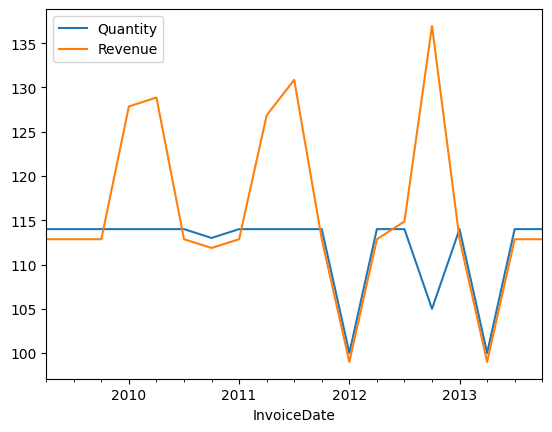

In [103]:
df = (dataframe[['InvoiceDate','Quantity','UnitPrice']]
       .dropna()
       .rename(columns = {'UnitPrice':'Revenue'})
       .groupby(pd.Grouper(key="InvoiceDate", freq='3M')).sum()
       .head(-1).tail(-1)    # drop first and last period
      )

display(df.plot())

(24, 1)


<Axes: xlabel='Country'>

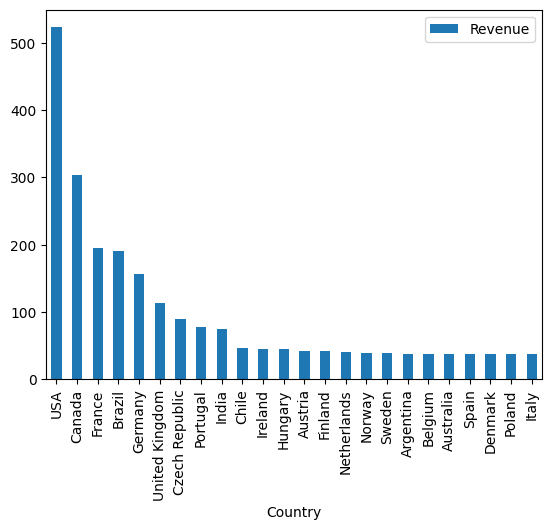

In [139]:
df = (dataframe[['Country','UnitPrice']]
       .rename(columns = {'UnitPrice':'Revenue'})
       .groupby(pd.Grouper(key="Country")).sum()
       .sort_values(by = 'Revenue', ascending = False)
      )

print(df.shape)
display(df.plot(kind='bar'))

                         Media  Revenue
1              MPEG audio file  1956.24
3  Protected MPEG-4 video file   220.89
2     Protected AAC audio file   144.54
4     Purchased AAC audio file     3.96
0               AAC audio file     2.97


<Axes: xlabel='Media'>

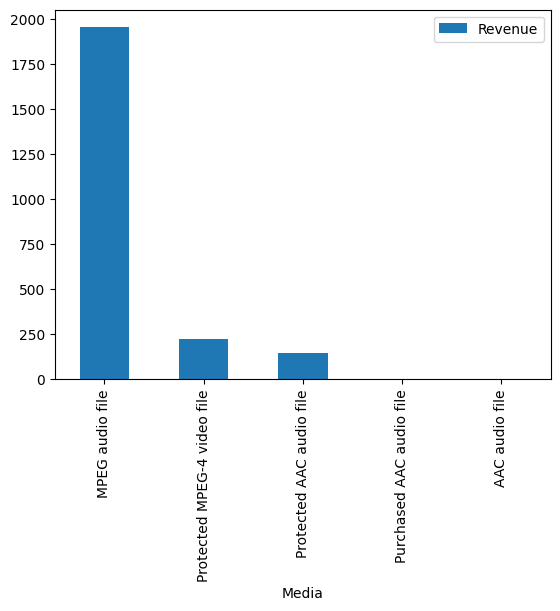

In [187]:
df = (dataframe[['Media','UnitPrice']]
       .rename(columns = {'UnitPrice':'Revenue'})
       .groupby("Media",as_index=False)["Revenue"].sum()
       .sort_values(by="Revenue",ascending = False)
      )

print(df.tail())
display(df.plot(kind='bar', x='Media'))

In [176]:
df = (dataframe[['Genre','Quantity']]
       .rename(columns = {'Quantity':'# Sold'})
       .groupby(pd.Grouper(key="Genre")).sum()
      )

df2 = (dataframe[['Genre','TrackId']]
       .rename(columns = {'TrackId':'# Tracks available'})
       .groupby(pd.Grouper(key="Genre")).count()
      )

df3 = pd.merge(left=df, right=df2, left_on='Genre', right_on='Genre')

display(df3.plot(kind='scatter', x='# Sold', y='# Tracks available'))

C:\Users\blinklet\AppData\Local\Temp\ipykernel_17296\3323562139.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .groupby(pd.Grouper(key="Genre"), level=0).sum()


KeyError: 'Genre'

<Axes: xlabel='# Sold', ylabel='# Tracks available'>

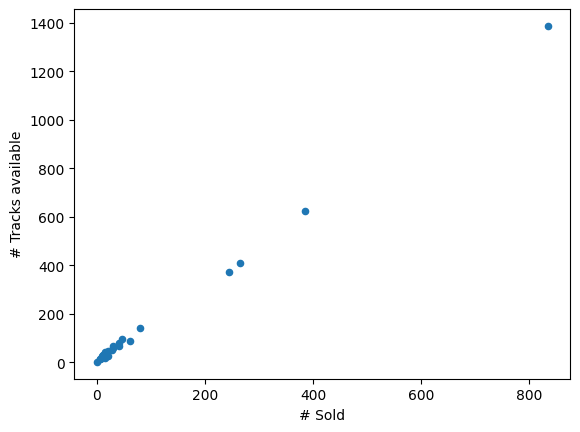

In [208]:
df = (dataframe[['Genre','Quantity']]
       .rename(columns = {'Quantity':'# Sold'})
       .groupby("Genre", as_index=False)['# Sold'].sum()
      )

df2 = (dataframe[['Genre','TrackId']]
       .rename(columns = {'TrackId':'# Tracks available'})
       .groupby("Genre", as_index=False)["# Tracks available"].count()
      )

df3 = pd.merge(df, df2)

display(df3.plot(kind='scatter', x='# Sold', y='# Tracks available'))

In [206]:
df = (dataframe[['Genre','Quantity','TrackId']]
       .groupby(["Genre","TrackId"], as_index=False)['Quantity'].sum()
      ).groupby("Genre", as_index=False)["TrackId"].count()

display(df)

# df2 = (dataframe[['Genre','TrackId']]
#        .rename(columns = {'TrackId':'# Tracks available'})
#        .groupby("Genre", as_index=False)["# Tracks available"].count()
#       )

# df3 = pd.merge(df, df2)

#display(df.plot(kind='scatter', x='Quantity', y='TrackId'))

,Genre,TrackId
0,Alternative,40
1,Alternative & Punk,332
2,Blues,81
3,Bossa Nova,15
4,Classical,74
5,Comedy,17
6,Drama,64
7,Easy Listening,24
8,Electronica/Dance,30
9,Heavy Metal,28
